<!-- dom:TITLE: STAT 5102 Regression in Practice Final Project -->
# <center>Generalised Linear Model for Estimating Mortality Rate Using Development Indicators</center>


<!-- dom:AUTHOR: CHAN, Yiu Fung Frankie, 1155010561 -->
<!-- Author: -->  
**<h5><center>CHAN, Yiu Fung Frankie,  1155010561</center></h5>**  
<!-- dom:AUTHOR: LI Wai Lan, 1155118254 -->
<!-- Author: -->  
**<h5><center>LI Wai Lan,  1155118254</center></h5>** 
<!-- dom:AUTHOR: WONG, Tsz Wing, 1004666311 -->
<!-- Author: -->  
**<h5><center>WONG, Tsz Wing,  1004666311</center></h5>**
<!-- dom:AUTHOR: WONG, Yiu Chung, 1155017920 -->
<!-- Author: -->  
**<h5><center>WONG, Yiu Chung,  1155017920</center></h5>** 


Date: **Nov 20, 2018**

In this study, we investigate the dataset obtained from The World Bank: World Development Indicators. A Generalised Linear Model is used to perform a prediction analysis on the response variable: Mortality rate, using ???(number) predictor variables.

In [575]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import data

In [576]:
#change working directory to 5102 project folder
from sys import platform

current_OS = platform
if current_OS == "darwin": #MacOS
    os.chdir(r"/Users/chung/Google Drive/2018R1 Regression in Practice (STAT5102)/5012 Project")

#read project_data.sas7bdat
world_bank = pd.read_sas(r"project_data.sas7bdat", encoding="utf-8")

# Preliminary data wrangling 

In [577]:
#Drop the column Year and YearCode
world_bank.drop(["Year", "YearCode", "Country Name"], axis=1, inplace = True)

#remove columns with more than 20% Nan
na_portion = world_bank.isna().sum() / len(world_bank)
world_bank = world_bank.loc[:, na_portion < .2]

#remove case if Mortality rate, under-5 (per 1,000 live births) is Nan
world_bank = world_bank.loc[world_bank["Mortality rate, under-5 (per 1,0"].notnull(),:] 

In [578]:
#import functions for converting country code into continents codes
import pycountry #pycountry provides the ISO databases for the standards:
from pycountry_convert import (
    map_countries,
    country_alpha2_to_country_name,
    country_name_to_country_alpha2,
    country_alpha3_to_country_alpha2,
    country_alpha2_to_continent_code,
    COUNTRY_NAME_FORMAT_UPPER
)

#convert country code into continents codes
continents = []
fail_codes = []
for country_code in world_bank["Country Code"]:
    try:
        alpha2 = country_alpha3_to_country_alpha2(country_code)
        continent = country_alpha2_to_continent_code(alpha2)
    except KeyError:
        fail_codes.append(country_code)
        continents.append("999") #temporary place holder
    else:    
        continents.append(continent)
        
#see what's in the continents list variable
print(set(continents))

#insert continents into the world_bank dataframe
#insert as column 2, named "Continent"
world_bank.insert(2, "Continent", continents)

#manually impute fail codes
fail_codes_continents = ["EU", "AF", "EU", "AS", "AS"] #in this order. I checked manually.
fail_code_dict = dict(zip(fail_codes, fail_codes_continents))

#for columns with Country Code that matches elements in the fail_codes variable, 
#replace their Continent value (whcih should be 999 for now) with the elements in fail_codes_continents
for code, continent in fail_code_dict.items():
    world_bank.loc[world_bank["Country Code"] == code, "Continent"] = continent
    
#we no longer need country code
world_bank.drop(["Country Code"], axis=1, inplace = True)   

#update, data with continents looks bad. Removed (23/11/2018)
world_bank.drop(["Continent"], axis=1, inplace = True)   

{'999', 'EU', 'SA', 'NA', 'OC', 'AF', 'AS'}


In [579]:
#Age dependency ratio (% of working-age population) includes people who are below 15 or above than 64
#Age dependency ratio, young (% of working-age population) only includes people below 15
#hence the first one includes redundant information

world_bank.rename(index = str, columns={"Age dependency ratio (% of worki": "Age dependency ratio, old",
                                       "Age dependency ratio, young (% o": "Age dependency ratio, young"},
                 inplace = True)

world_bank["Age dependency ratio, old"] -= world_bank["Age dependency ratio, young"]

In [580]:
show_all = 0
if show_all:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(world_bank)
else:
    display(world_bank.head())

,Adjusted savings: education expe,Adolescent fertility rate (birth,"Age dependency ratio, old","Age dependency ratio, young",Agricultural land (% of land are,"Birth rate, crude (per 1,000 peo","Fertility rate, total (births pe",GDP (constant 2005 US$),GDP growth (annual %),"GDP per capita, PPP (constant 20",...,"Life expectancy at birth, female","Life expectancy at birth, male (","Life expectancy at birth, total","Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0","Mortality rate, under-5, female","Mortality rate, under-5, male (p",Population growth (annual %),"Immunization, DPT (% of children","Immunization, measles (% of chil"
0,NaN,99.095600,4.397600,98.722026,58.123668,37.952,5.659,1.024325e+10,8.433290,1183.045192,...,60.877,58.384,59.600098,74.3,103.7,100.4,106.7,2.458417,66.0,62.0
1,2.842804,16.994600,15.062236,34.036210,43.843066,12.607,1.741,1.072515e+10,3.500000,7791.755363,...,80.149,73.959,76.978512,16.1,18.1,16.3,19.7,-0.033072,99.0,99.0
2,4.467196,9.894599,6.945180,39.796430,17.370914,24.514,2.817,1.166263e+11,3.600000,7249.230810,...,72.229,69.081,70.616610,18.4,21.5,19.0,23.8,1.850438,95.0,95.0
4,2.889150,NaN,NaN,NaN,42.765957,9.800,1.220,NaN,NaN,NaN,...,NaN,NaN,NaN,2.9,3.5,3.1,3.8,-0.960625,99.0,99.0
5,3.516770,178.994000,4.864592,96.050884,46.835646,46.327,6.218,5.037116e+10,3.407644,5048.113176,...,52.138,49.241,50.654171,104.6,173.1,164.5,181.1,3.235950,91.0,93.0


In [581]:
#export world_bank to excel file to share with groupmates (19 Nov 2018)
share = 0
if share:
    writer = pd.ExcelWriter('world_bank.xlsx')
    world_bank.to_excel(writer, 'Sheet1')
    writer.save()

# Regression Model

\begin{equation}
Y = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \epsilon
\end{equation}

where 

\begin{equation}
\epsilon \sim N(\mu,\sigma^2)
\end{equation}

We are regressing a continous variable Y on a set of Xs. The model assumes Y to be the sum of all Xs multiplied by their corrosponding coefficients, plus random normal error. This model works well if we can plug in numbers on the RHS and get the corrosponding value on the LHS. Note that the sum on the RHS can sometimes be negative depending on the input and coefficients. Unfortunately, our response variable, Mortality rate, under-5 (per 1,000 births), can not take negative values; our model is broken when ever the sum on of the RHS comes out negative. 

Because of this, we perform a log transformation on the response variable. 

\begin{equation}
\log(Y) = \beta_0 + \beta_1 X_1 + ... + \beta_p X_p + \epsilon
\end{equation}

With a log transformation on the response variable, values on both sides of the equation may take negative values, and we are no longer restricted by the fact that the response can only take positive values. 

In [582]:
world_bank["Mortality rate, under-5 (per 1,0"] = world_bank["Mortality rate, under-5 (per 1,0"].apply(np.log)

# Exploratory Data Analysis

Not all variables are useful in the dataset. Some might be highly correlated with each other and thus create redundency and colinearity/multicolinearity.

Let's start by looking at the response variable, i.e. the Mortality rates

In [583]:
mortality_rates = list(world_bank.columns)
mortality_rates = [item for item in mortality_rates if item.startswith('Mortality')]
corr = world_bank[mortality_rates].corr()
corr.style.background_gradient(low=.9)

,"Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0","Mortality rate, under-5, female","Mortality rate, under-5, male (p"
"Mortality rate, infant (per 1,00",1,0.920163,0.982495,0.986274
"Mortality rate, under-5 (per 1,0",0.920163,1,0.879971,0.892869
"Mortality rate, under-5, female",0.982495,0.879971,1,0.99851
"Mortality rate, under-5, male (p",0.986274,0.892869,0.99851,1


We see that everything is highly corrrelated; they are essentially the same measure. Highly correlated predictors can lead to instability in our estimator, as well as increased variance. 

Not only do these variables covary, their vaule are also extremely close to each other. It is very tempting for us to just use a single one of these variables to predict our response variable. Let's do this and see what's gonna happen if we just pick one of these predictors to predict Mortality rate, under-5 (per 1,000 births)? Here we use Mortality rate, infant (per 1,000 births).

'Test R^2: 0.8818531381213884'

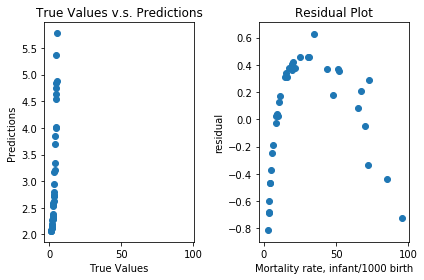

In [584]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(world_bank["Mortality rate, infant (per 1,00"].values, 
                                                    world_bank["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = 5102)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
residuals = y_test - predictions

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, sharex = True)
ax1.scatter(y_test, predictions)
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predictions")
ax1.set_title("True Values v.s. Predictions")

ax2.scatter(X_test, residuals)
ax2.set_xlabel("Mortality rate, infant/1000 birth")
ax2.set_ylabel("residual")
ax2.set_title("Residual Plot")
plt.tight_layout()

"Test R^2: " + str(model.score(X = X_test, y = y_test))

The residual plot is showing some very bizarre pattern: the error does not remain constant as infant mortality rate increase. This suggests either heteroscedasticity or nonlinear relationship between predictor and outcome.

The bottom line is, we cannot use Simple Linear Regression (OLS) simply because high correlation between predictor and outcome. We will not further investigate OLS in this report.

How about the other two mortality indicators? After some eyeball investigation, it is not difficult to see that our response variable is merely the average of Male/Female mortality rate. Hence we will not include these two into our analysis because they are essentially the same thing as our response variable. However, it might be interesting to see how the DIFFERENCE in Male/Female mortality rate affects our response variable. Therefore we can consider adding the DIFFERENCE in Male/Female mortality rate into our dataset.

In [585]:
Mortality_gender_diff = (world_bank["Mortality rate, under-5, male (p"] -
                         world_bank["Mortality rate, under-5, female"])
#add gender difference
world_bank.insert(22, "Mortality rate, under-5, Gender Difference", Mortality_gender_diff) 
#remove mortality rate for male and female
world_bank.drop(["Mortality rate, under-5, male (p", "Mortality rate, under-5, female"], axis=1,inplace=True)

In [586]:
#do the same thing for Life expectancy 
Life_expt_gender_diff = (world_bank["Life expectancy at birth, female"] -
                         world_bank["Life expectancy at birth, male ("])
#add gender difference
world_bank.insert(15, "Life expectancy at birth, Gender Difference", Life_expt_gender_diff) 
#remove Life expectency for male and female
world_bank.drop(["Life expectancy at birth, female", "Life expectancy at birth, male ("], axis=1,inplace=True)

In [587]:
corr = world_bank.corr()
corr.style.background_gradient(low=.9)

,Adjusted savings: education expe,Adolescent fertility rate (birth,"Age dependency ratio, old","Age dependency ratio, young",Agricultural land (% of land are,"Birth rate, crude (per 1,000 peo","Fertility rate, total (births pe",GDP (constant 2005 US$),GDP growth (annual %),"GDP per capita, PPP (constant 20",Health expenditure per capita (c,"Health expenditure, public (% of","Health expenditure, public _0001","Inflation, GDP deflator (annual","Life expectancy at birth, Gender Difference","Life expectancy at birth, total","Mortality rate, infant (per 1,00","Mortality rate, under-5 (per 1,0",Population growth (annual %),"Mortality rate, under-5, Gender Difference","Immunization, DPT (% of children","Immunization, measles (% of chil"
Adjusted savings: education expe,1,-0.292774,0.290058,-0.280623,0.141968,-0.266506,-0.259487,0.0150936,-0.182666,0.199718,0.219507,0.527322,0.23915,-0.18007,0.104472,0.20192,-0.271949,-0.300716,-0.266095,-0.230657,0.258558,0.212113
Adolescent fertility rate (birth,-0.292774,1,-0.540933,0.821006,0.114102,0.81255,0.803699,-0.165693,0.183916,-0.557563,-0.440839,-0.384648,-0.138309,0.31301,-0.452525,-0.746428,0.749869,0.758412,0.399391,0.677006,-0.507069,-0.495785
"Age dependency ratio, old",0.290058,-0.540933,1,-0.703416,0.00890476,-0.728219,-0.642618,0.290694,-0.31013,0.53436,0.659973,0.638029,0.400271,-0.425013,0.483438,0.63395,-0.613251,-0.769703,-0.645321,-0.626991,0.308378,0.306428
"Age dependency ratio, young",-0.280623,0.821006,-0.703416,1,0.156231,0.972746,0.960613,-0.209291,0.243092,-0.64782,-0.485387,-0.397296,-0.203905,0.309887,-0.578549,-0.814347,0.831258,0.858313,0.479836,0.778152,-0.519715,-0.556877
Agricultural land (% of land are,0.141968,0.114102,0.00890476,0.156231,1,0.167074,0.152415,0.0272696,0.000903562,-0.269412,-0.0956058,0.0662426,0.0421447,0.0444561,-0.0441191,-0.256789,0.216122,0.223779,-0.131276,0.236131,-0.0287278,-0.0134467
"Birth rate, crude (per 1,000 peo",-0.266506,0.81255,-0.728219,0.972746,0.167074,1,0.98164,-0.215458,0.238734,-0.615858,-0.491984,-0.449557,-0.262571,0.380241,-0.585261,-0.847936,0.865892,0.875559,0.56488,0.812333,-0.50943,-0.526999
"Fertility rate, total (births pe",-0.259487,0.803699,-0.642618,0.960613,0.152415,0.98164,1,-0.182266,0.215828,-0.546319,-0.411226,-0.372427,-0.220158,0.352923,-0.591802,-0.816337,0.850403,0.822795,0.555649,0.769139,-0.546317,-0.578464
GDP (constant 2005 US$),0.0150936,-0.165693,0.290694,-0.209291,0.0272696,-0.215458,-0.182266,1,-0.00384567,0.304043,0.465385,0.229902,0.217946,-0.119411,0.0502422,0.21832,-0.179857,-0.226836,-0.128954,-0.211145,0.110009,0.0945762
GDP growth (annual %),-0.182666,0.183916,-0.31013,0.243092,0.000903562,0.238734,0.215828,-0.00384567,1,-0.162424,-0.222854,-0.337077,-0.234733,0.112917,-0.135839,-0.225368,0.242896,0.259974,0.301452,0.209294,-0.167103,-0.0860036
"GDP per capita, PPP (constant 20",0.199718,-0.557563,0.53436,-0.64782,-0.269412,-0.615858,-0.546319,0.304043,-0.162424,1,0.806713,0.431808,0.227654,-0.215574,0.139139,0.638375,-0.59197,-0.757272,0.00166286,-0.617244,0.323703,0.306732


# Coefficient of Variation
Compare spread of each numeric variables

In [588]:
world_bank_numeric = world_bank.copy() #make copy of dataset so don't mess up
world_bank_numeric = world_bank_numeric.iloc[:, 3:]
np.std(world_bank_numeric)/np.mean(world_bank_numeric)

Age dependency ratio, young                    0.477310
Agricultural land (% of land are               0.552921
Birth rate, crude (per 1,000 peo               0.482061
Fertility rate, total (births pe               0.506147
GDP (constant 2005 US$)                        4.123690
GDP growth (annual %)                          0.959985
GDP per capita, PPP (constant 20               1.078324
Health expenditure per capita (c               1.696693
Health expenditure, public (% of               0.598193
Health expenditure, public _0001               0.394018
Inflation, GDP deflator (annual                1.085141
Life expectancy at birth, Gender Difference    0.519429
Life expectancy at birth, total                0.135802
Mortality rate, infant (per 1,00               0.926710
Mortality rate, under-5 (per 1,0               0.374492
Population growth (annual %)                   0.967304
Mortality rate, under-5, Gender Difference     0.843964
Immunization, DPT (% of children               0

Some variables shows extreme variation. e.g. GDP (constant 2005 US$) 

# Plotting distributions of numeric variables

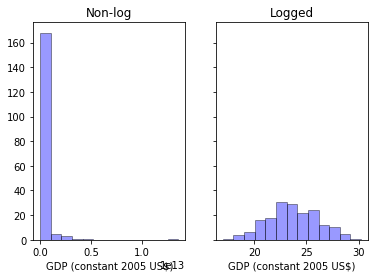

In [589]:
plot_data = world_bank_numeric["GDP (constant 2005 US$)"].dropna()
plot_data_log = plot_data.apply(np.log)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.set_title("Non-log")
ax2.set_title("Logged")

plot_1 = sns.distplot(plot_data, hist=True, kde=False,
                      bins=int(plot_data.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax1)

plot_2 = sns.distplot(plot_data_log, hist=True, kde=False,
                      bins=int(plot_data_log.shape[0]**.5), 
                      color = 'blue',
                      hist_kws={'edgecolor':'black'},
                      ax=ax2)

In [ ]:
scipy.stats.moment(hihi, moment=3)

# Multiple Regression

Use all first order terms

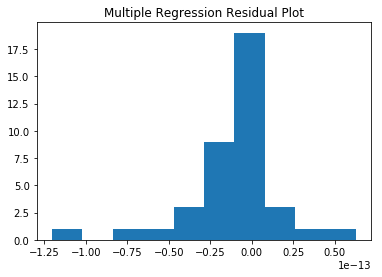

In [590]:
multi_reg_data = world_bank.copy()
multi_reg_data = lasso_data.fillna(multi_reg_data.mean())

X_train, X_test, y_train, y_test = train_test_split(multi_reg_data, 
                                                    multi_reg_data["Mortality rate, under-5 (per 1,0"].values, 
                                                    test_size=0.2, 
                                                    random_state = 5102)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
residuals = y_test - predictions

plt.hist(residuals)
plt.title("Multiple Regression Residual Plot")
plt.show()

from statsmodels.graphics.gofplots import qqplot
#qqplot(residuals, line='s')
#Do normality test

# Lasso Regression

There are relatively few countries around the world compared to the amount of data we generate. After some initial wrangling, we only have 192 countries remaining in our dataset, with 26 first order predictors (and 300 if we consider interaction and second order terms!). Low number of observations put us at risk of overfitting the data, which inflates the variance of our model. Feature selection is therefore needed so we won't be using all 26 predictors (or 300). Also, from the correlation matrix presented above, we know that some predictors are highly correlated and are almot linearly dependent. Hence, we are not at risk of increasing bias if we know which ones to throw away.

The Lasso regulisation impose a L1 penalty on the coefficients: every coefficient is being shrinked, and some even as low as zero. This is practically equal to feature selection since feature with zero coefficient has no effect in the model.  

In [591]:
from sklearn.linear_model import Lasso

lasso_data = world_bank.copy()
lasso_data = lasso_data.fillna(lasso_data.mean())

#dummies = pd.get_dummies(lasso_data["Continent"])
y = lasso_data["Mortality rate, under-5 (per 1,0"]
# Drop Salary (target) and columns for which we created dummy variables
#X_ = lasso_data.drop(["Mortality rate, under-5 (per 1,0", "Continent"], axis=1)
X = lasso_data.drop(["Mortality rate, under-5 (per 1,0"], axis=1)
# Define the feature set X.
# dummies = pd.get_dummies(lasso_data["Continent"])
# X = pd.concat([X_, dummies], axis=1)

In [592]:
alphas = np.logspace(3, -2, 50)*0.5
lasso = Lasso(max_iter=10000, normalize=True, random_state = 5102)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
np.shape(coefs)

(50, 21)

Text(0.5,1,'Change in coefficient across\ndifferent values of alpha')

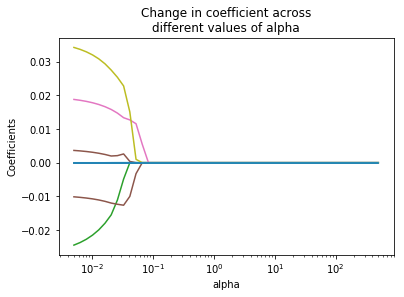

In [593]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title("Change in coefficient across\ndifferent values of alpha")

In [594]:
# Use the cross-validation package to split data into training and test sets
from sklearn.linear_model import LassoCV
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=5102)

lassocv = LassoCV(alphas=None, cv=5, max_iter=100000, normalize=True, random_state = 5102)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_train, y_train)
print("mse = ", mean_squared_error(y_test, lasso.predict(X_test)))
print("best model coefficients:")
pd.Series(lasso.coef_, index=X.columns)[lasso.coef_ != 0.000000]

Alpha= 0.001742106915117784
mse =  0.07334439503431461
best model coefficients:


Adjusted savings: education expe             -1.023531e-02
Age dependency ratio, old                    -2.849142e-02
Agricultural land (% of land are              5.860632e-05
GDP (constant 2005 US$)                       1.044525e-13
GDP per capita, PPP (constant 20             -1.687987e-05
Health expenditure per capita (c             -7.763449e-05
Life expectancy at birth, total              -8.259281e-03
Mortality rate, infant (per 1,00              1.797685e-02
Population growth (annual %)                  4.693717e-02
Mortality rate, under-5, Gender Difference    3.756489e-02
Immunization, DPT (% of children             -6.989612e-05
Immunization, measles (% of chil             -2.599171e-03
dtype: float64

In [595]:
lassocv.alpha_

0.001742106915117784

In [596]:
lasso_features = list(pd.Series(lasso.coef_, index=X.columns)[lasso.coef_ != 0.000000].index)
# lasso_features.remove('NA')
# lasso_features.remove('OC')
corr = world_bank[lasso_features].corr()
corr.style.background_gradient(low=.9)

,Adjusted savings: education expe,"Age dependency ratio, old",Agricultural land (% of land are,GDP (constant 2005 US$),"GDP per capita, PPP (constant 20",Health expenditure per capita (c,"Life expectancy at birth, total","Mortality rate, infant (per 1,00",Population growth (annual %),"Mortality rate, under-5, Gender Difference","Immunization, DPT (% of children","Immunization, measles (% of chil"
Adjusted savings: education expe,1,0.290058,0.141968,0.0150936,0.199718,0.219507,0.20192,-0.271949,-0.266095,-0.230657,0.258558,0.212113
"Age dependency ratio, old",0.290058,1,0.00890476,0.290694,0.53436,0.659973,0.63395,-0.613251,-0.645321,-0.626991,0.308378,0.306428
Agricultural land (% of land are,0.141968,0.00890476,1,0.0272696,-0.269412,-0.0956058,-0.256789,0.216122,-0.131276,0.236131,-0.0287278,-0.0134467
GDP (constant 2005 US$),0.0150936,0.290694,0.0272696,1,0.304043,0.465385,0.21832,-0.179857,-0.128954,-0.211145,0.110009,0.0945762
"GDP per capita, PPP (constant 20",0.199718,0.53436,-0.269412,0.304043,1,0.806713,0.638375,-0.59197,0.00166286,-0.617244,0.323703,0.306732
Health expenditure per capita (c,0.219507,0.659973,-0.0956058,0.465385,0.806713,1,0.548139,-0.468222,-0.205416,-0.493764,0.240822,0.192895
"Life expectancy at birth, total",0.20192,0.63395,-0.256789,0.21832,0.638375,0.548139,1,-0.926612,-0.37079,-0.870756,0.546246,0.505184
"Mortality rate, infant (per 1,00",-0.271949,-0.613251,0.216122,-0.179857,-0.59197,-0.468222,-0.926612,1,0.4118,0.899693,-0.605054,-0.560973
Population growth (annual %),-0.266095,-0.645321,-0.131276,-0.128954,0.00166286,-0.205416,-0.37079,0.4118,1,0.368397,-0.225333,-0.215661
"Mortality rate, under-5, Gender Difference",-0.230657,-0.626991,0.236131,-0.211145,-0.617244,-0.493764,-0.870756,0.899693,0.368397,1,-0.496836,-0.467691


Features that remains are not highly correlated to each other.

In [ ]:
# Best subset on first order variables

Might have to drop cases if too many Nan, but wait until after variabel selection.

lots = world_bank.T.isna().sum() > 5

lots.sum()

# See how many  polynomial features can there be using the PolynomialFeatures function; to generate quadratic terms for Polynomial regression

In [141]:
#example
#test PolynomialFeatures function
data = pd.DataFrame.from_dict({
    'x': np.random.randint(low=1, high=10, size=5),
    'y': np.random.randint(low=-1, high=1, size=5),
})

p = PolynomialFeatures(degree=2).fit(data)
p.get_feature_names(data.columns)

['1', 'x', 'y', 'x^2', 'x y', 'y^2']

In [480]:
p.transform(data)

array([[ 1.,  2., -1.,  4., -2.,  1.],
       [ 1.,  3.,  0.,  9.,  0.,  0.],
       [ 1.,  6.,  0., 36.,  0.,  0.],
       [ 1.,  7.,  0., 49.,  0.,  0.],
       [ 1.,  8., -1., 64., -8.,  1.]])

In [385]:
from sklearn.preprocessing import PolynomialFeatures

#make a copy of our dataset: dont mess with our dataset
#impute data with mean coz PolynomialFeatures function can't work with dataset with missing data
poly = world_bank_numeric.drop(["Mortality rate, under-5 (per 1,0"], axis=1)
poly = poly.fillna(world_bank_numeric.mean())

#have to deal with continent column.
degree = 2
quadratic_terms = PolynomialFeatures(degree = degree).fit(poly)
num_terms = len(quadratic_terms.get_feature_names(poly.columns))

#transform data into their corrosponding quadratic form
quadratic_data = quadratic_terms.transform(poly)
quadratic_data = pd.DataFrame(data = quadratic_data)

"There are a total of " + str(num_terms) + " first, second, and interaction terms"

'There are a total of 210 first, second, and interaction terms'

# PCA on 1st order variables

In [387]:
from sklearn.preprocessing import StandardScaler


# Separating out the features
x = world_bank_numeric.drop(["Mortality rate, under-5 (per 1,0"], axis=1)
#PCA cannot handle missing data
x = x.fillna(x.mean())
# Separating out the target
y = world_bank_numeric["Mortality rate, under-5 (per 1,0"].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

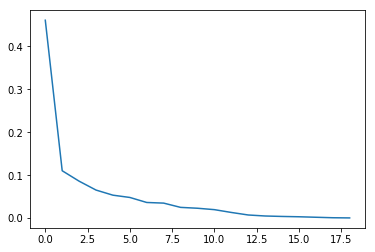

In [388]:
from sklearn.decomposition import PCA
pca = PCA(n_components=x.shape[1])
principalComponents = pca.fit_transform(x)
var = pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var)

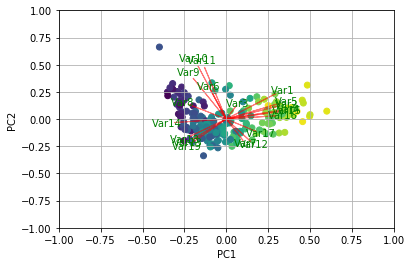

In [389]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [390]:
pca.components_

array([[ 2.91320613e-01,  3.15190634e-01,  6.12220299e-02,
         3.21705375e-01,  3.13844995e-01, -9.22330828e-02,
         9.90635226e-02, -2.24701389e-01, -1.96101266e-01,
        -1.67272370e-01, -1.28869755e-01,  1.44581155e-01,
        -1.98691536e-01, -3.06698347e-01,  3.13192282e-01,
         2.92995139e-01,  1.77627164e-01, -2.14219724e-01,
        -2.05836405e-01],
       [ 2.29938359e-01,  1.20916521e-01,  1.24384270e-01,
         8.01287432e-02,  1.42780716e-01,  2.62059481e-01,
        -1.93815581e-01,  1.35642792e-01,  3.72992213e-01,
         4.84511347e-01,  4.73469076e-01, -2.03584570e-01,
        -1.85414431e-01, -3.15906950e-02,  6.74401699e-02,
         3.00408215e-02, -1.12471480e-01, -1.56976348e-01,
        -2.19038661e-01],
       [-6.19005762e-02, -1.98795135e-02, -3.93818536e-01,
         2.58994949e-02,  6.04696027e-02,  2.12198371e-01,
         1.89952821e-01,  4.64426644e-01,  3.15075333e-01,
        -1.28312084e-01, -1.50066930e-01,  1.79444957e-01,
    

# PCA on 2nd order variables

In [391]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
quadratic_x = quadratic_data
# Separating out the target
quadratic_y = world_bank_numeric["Mortality rate, under-5 (per 1,0"].values
# Standardizing the features
quadratic_x = StandardScaler().fit_transform(quadratic_x)

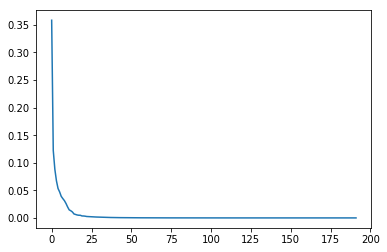

In [392]:
from sklearn.decomposition import PCA
quadratic_pca = PCA(n_components = quadratic_x.shape[1])
principalComponents = quadratic_pca.fit_transform(quadratic_x)
quadratic_var = quadratic_pca.explained_variance_ratio_
quadratic_var1 = np.cumsum(np.round(quadratic_var, decimals=4)*100)
plt.plot(quadratic_var)

In [393]:
variation_cutoff = 95
PC_count = len(quadratic_var1[quadratic_var1 < variation_cutoff])

(str(PC_count) + 
 " principle components (generated from 1st, 2nd, and interaction terms) are required to explain " +
 str(variation_cutoff) +
 "% of variation.")

'18 principle components (generated from 1st, 2nd, and interaction terms) are required to explain 95% of variation.'

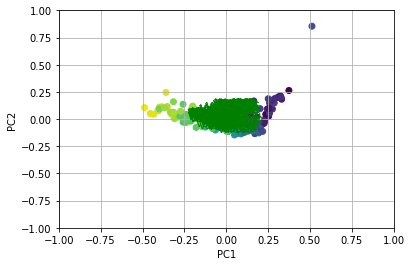

In [394]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(principalComponents[:,0:2],np.transpose(quadratic_pca.components_[0:2, :]))
plt.show()

In [395]:
quadratic_pca.components_.shape

(192, 210)

In [396]:
principalComponents.shape

(192, 192)